In [254]:
import os
import zipfile
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn

from torch.optim import AdamW
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from torchvision.models.video import r3d_18, R3D_18_Weights
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import ndimage
from skimage import measure, morphology

In [117]:
def rescale_to_hu(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    # Ensure dicom file is in Hounsfield unit by rescaling
    intercept = dcm.RescaleIntercept
    slope = dcm.RescaleSlope
    hu_image = dcm.pixel_array * slope + intercept
    return hu_image

In [39]:
def visualize_ct_scan(dcm_dir: str, file_list: list[str]):
  # Visualize CT scan into 3D mesh
  pixel3d = []
  for file in file_list:
    file = os.path.join(dcm_dir, file)
    ds = pydicom.dcmread(file)
    hu_image = rescale_to_hu(ds)
    pixel3d.append(hu_image)

  pixel3d = np.array(pixel3d)
  pixel3d = pixel3d[::-1]

  p = pixel3d.transpose(2,1,0)
  verts, faces, normals, values = measure.marching_cubes(p, -500)
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')
  mesh = Poly3DCollection(verts[faces], alpha=0.1)
  face_color = [0.5, 0.5, 1]
  mesh.set_facecolor(face_color)
  ax.add_collection3d(mesh)
  ax.set_xlim(0, p.shape[0])
  ax.set_ylim(0, p.shape[1])
  ax.set_zlim(0, p.shape[2])

  plt.show()

In [203]:
# Organize data per patient
def load_train_dcm(patient_ids: list[str] = None):
    if patient_ids is None:
        patient_ids = os.listdir('../osic-pulmonary-fibrosis-progression/train/')
    train_patient_dcm = {}
    for patient in patient_ids:
        patient_dir = os.path.join('../osic-pulmonary-fibrosis-progression/train/', patient)
        files = os.listdir(patient_dir)
        train_patient_dcm[patient] = sorted(files, key=lambda x: int(x.split('.')[0]))
    return train_patient_dcm

In [138]:
def window_image(image, window_center, window_width):
    # CT Windowing, min = window_center - window_width // 2, max = window_center + window_width // 2
    # Clip values outside of window to img_min or img_max
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

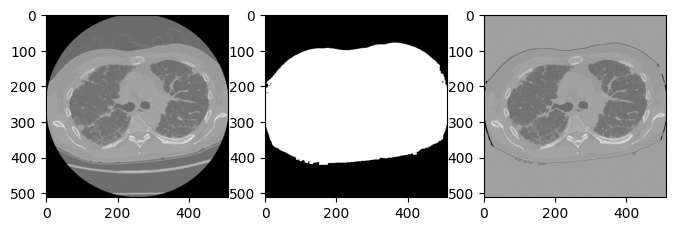

In [168]:
def get_mask(image: np.ndarray, window_level: int = 40, window_width: int = 80):
    # Reference wl and ww values: https://radiopaedia.org/articles/windowing-ct
    # Default value for bone tissue

    thresholded_image = window_image(image, window_level, window_width)

    segmentation = morphology.dilation(thresholded_image, np.ones((4, 4)))
    labels, label_nb = ndimage.label(segmentation)

    label_count = np.bincount(labels.ravel().astype(int))
    label_count[0] = 0

    mask = labels == label_count.argmax()

    # Improve the mask
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))

    return mask

# Scan Preprocessing Example
# https://www.sciencedirect.com/science/article/pii/S2589871X23000062

path = '../osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/13.dcm'
fig, axes = plt.subplots(1, 3, figsize=(8, 8))

dcm = pydicom.dcmread(path)
hu_scan = rescale_to_hu(dcm)
mask = get_mask(hu_scan)

axes[0].imshow(hu_scan, cmap='gray')
axes[1].imshow(mask, cmap='gray')
axes[2].imshow(mask * hu_scan, cmap='gray')


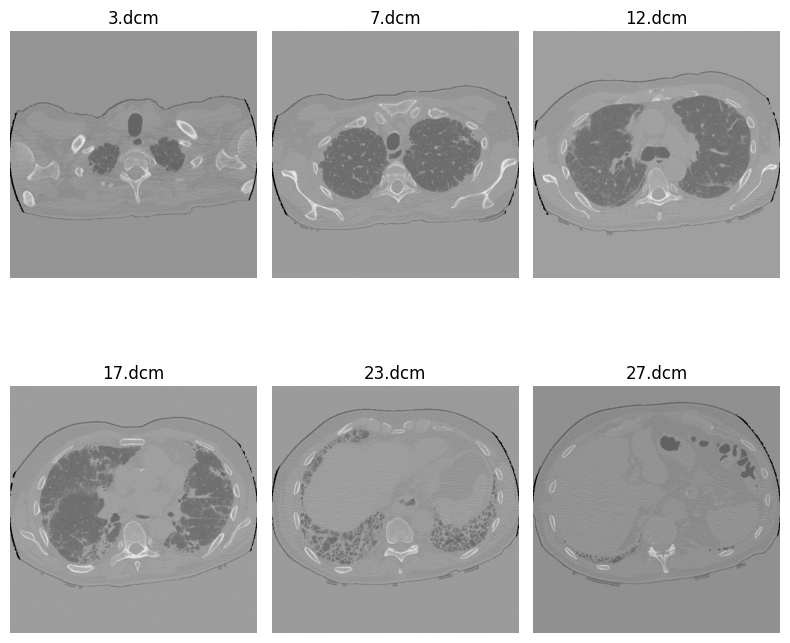

In [177]:
# Visualize CT scan slice
paths = []
paths.append('../osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/3.dcm')
paths.append('../osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/7.dcm')
paths.append('../osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/12.dcm')
paths.append('../osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/17.dcm')
paths.append('../osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/23.dcm')
paths.append('../osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/27.dcm')

dcms = [pydicom.dcmread(path) for path in paths]
original_hu_scans = [rescale_to_hu(dcm) for dcm in dcms]
hu_masks = [get_mask(scan) for scan in original_hu_scans]
hu_scans = [hu_scan * mask for hu_scan, mask in zip(original_hu_scans, hu_masks)]

fig, axes = plt.subplots(2, 3, figsize=(8, 8))
for row in range(2):
    for col in range(3):
        axes[row][col].imshow(hu_scans[row * 3 + col], cmap='gray')
        axes[row][col].set_title(paths[row * 3 + col].split('/')[-1])
        axes[row][col].axis('off')
plt.tight_layout()


In [169]:
train_patient = load_train_dcm()

# visualize_ct_scan('../osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430', train_patient['ID00007637202177411956430'])

In [202]:
# Extract baseline FVC measurement from csv
baseline_fvc = pd.read_csv('../osic-pulmonary-fibrosis-progression/train.csv')

baseline_fvc = baseline_fvc[baseline_fvc['Weeks'] == 0]
print(f'Only have {len(baseline_fvc)} patients with baseline (week 0) FVC measurement')
# Divide to 20:80 split
# pick 18 * 0.8 numbers randomly for training set
np.random.seed(42)
train_set = np.random.choice(len(baseline_fvc), int(len(baseline_fvc) * 0.8), replace=False)
test_set = np.setdiff1d(range(len(baseline_fvc)), train_set)
train_baseline_fvc = baseline_fvc.iloc[train_set][['Patient', 'FVC']]
test_baseline_fvc = baseline_fvc.iloc[test_set][['Patient', 'FVC']]
print("Training set:")
train_baseline_fvc

Only have 18 patients with baseline (week 0) FVC measurement
Training set:


,Patient,FVC
18,ID00010637202177584971671,3523
45,ID00014637202177757139317,3807
822,ID00219637202258203123958,6399
498,ID00129637202219868188000,2253
279,ID00078637202199415319443,1860
1267,ID00344637202287684217717,2066
1451,ID00405637202308359492977,1560
1415,ID00393637202302431697467,3562
1134,ID00312637202282607344793,1879
89,ID00025637202179541264076,2903


In [239]:
def load_patient_scans(dcm_dir: str, patient_ids: list[str]):
    # Load train dcm
    patient_dcms = load_train_dcm(patient_ids)
    patient_scans = {}
    for patient in patient_dcms.keys():
        scans = []
        for scan in patient_dcms[patient]:
            dcm = pydicom.dcmread(os.path.join(dcm_dir, patient, scan))
            scan = rescale_to_hu(dcm)
            # Mask out non-human objects
            mask = get_mask(scan)
            scan = scan * mask
            # Resize to 256x256
            scan = cv2.resize(scan, (256, 256))
            scans.append(scan)

        patient_scans[patient] = np.array(scans)
    return patient_scans

train_patient_scans = load_patient_scans('../osic-pulmonary-fibrosis-progression/train/', train_baseline_fvc['Patient'].tolist())
test_patient_scans = load_patient_scans('../osic-pulmonary-fibrosis-progression/train/', test_baseline_fvc['Patient'].tolist())

In [262]:
# Dict for baseline FVC
train_baseline_fvc_dict = {}
for row in train_baseline_fvc.itertuples():
    train_baseline_fvc_dict[row.Patient] = row.FVC

test_baseline_fvc_dict = {}
for row in test_baseline_fvc.itertuples():
    test_baseline_fvc_dict[row.Patient] = row.FVC

In [304]:
class ResNet3DRegressor(nn.Module):
  def __init__(self, pretrained: bool = True, inChannels: int = 1):
    super().__init__()
    weights = R3D_18_Weights.KINETICS400_V1 if pretrained else None
    backbone = r3d_18(weights=weights)
    if inChannels != 3:
      firstConv = backbone.stem[0]  # Conv3d(3, 64, kernel_size=(3,7,7), stride=(1,2,2), padding=(1,3,3))
      newConv = nn.Conv3d(inChannels, firstConv.out_channels, kernel_size=firstConv.kernel_size,
                          stride=firstConv.stride, padding=firstConv.padding, bias=firstConv.bias is not None)
      with torch.no_grad():
        # average RGB weights, repeat to inChannels
        avgWeight = firstConv.weight.mean(dim=1, keepdim=True)  # (64,1,3,7,7)
        newConv.weight[:, :, :, :, :] = avgWeight.repeat(1, inChannels, 1, 1, 1)
      backbone.stem[0] = newConv
    inFeatures = backbone.fc.in_features
    backbone.fc = nn.Linear(inFeatures, 1)
    self.backbone = backbone

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # Accept (N, D, H, W) or (N, C, D, H, W)
    if x.dim() == 4:
      x = x.unsqueeze(1)
    features = self.backbone(x).squeeze(1)  # (N,)
    print(features.shape, features)
    print(self.backbone.fc)
    return self.backbone.fc(features)

In [305]:
def train_model(model: nn.Module, epochs: int = 5, lr: float = 1e-4, weightDecay: float = 1e-4,
                       device: str = 'cuda' if torch.cuda.is_available() else 'cpu', gradClip: float | None = None):
  model = model.to(device)
  optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weightDecay)
  bestVal = float('inf')
  bestState = None

  for epoch in range(1, epochs + 1):
    # train
    model.train()
    running = 0.0
    count = 0
    for pid in train_patient_scans.keys():
      x = torch.tensor(train_patient_scans[pid], dtype=torch.float32).to(device)
      # Add channel dimension
      x = x.unsqueeze(1)
      print(x.shape)
      y = train_baseline_fvc_dict[pid]
      optimizer.zero_grad()
      # pred = model(x).squeeze(1)
      pred = model(x)
      print(pred, y)
      print(pred)
      loss = (pred - y) ** 2
      print(loss)
      loss.backward()
      if gradClip is not None:
        nn.utils.clip_grad_norm_(model.parameters(), gradClip)
      optimizer.step()
      running += loss.item() * x.size(0)
      count += x.size(0)
    trainMse = running / max(count, 1)

    # validate
    model.eval()
    running = 0.0
    count = 0
    with torch.no_grad():
      for pid in test_patient_scans.keys():
        x = torch.tensor(test_patient_scans[pid], dtype=torch.float32).to(device)
        # Add channel dimension
        x = x.unsqueeze(1)
        y = test_baseline_fvc_dict[pid]
        # pred = model(x).squeeze(1)
        pred = model(x)
        loss = (pred - y) ** 2
        running += loss.item() * x.size(0)
        count += x.size(0)
    valMse = running / max(count, 1)

    print(f"Epoch {epoch}: train MSE {trainMse:.4f} | val MSE {valMse:.4f}")

    if valMse < bestVal:
      bestVal = valMse
      bestState = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

  if bestState is not None:
    model.load_state_dict(bestState)
  return model


In [306]:
model = ResNet3DRegressor()
train_model(model)

torch.Size([106, 1, 256, 256])
torch.Size([106]) tensor([ 0.1958,  0.3814,  0.2306,  0.2902,  0.4121,  0.1367,  0.2443,  0.3094,
         0.3893,  0.2684,  0.2059,  0.1779,  0.2656,  0.0673,  0.2556,  0.3108,
         0.4232,  0.4053,  0.4557,  0.4834,  0.5200,  0.3594,  0.3136,  0.4078,
         0.4614,  0.5439,  0.5328,  0.4489,  0.4427,  0.2973,  0.3377,  0.2896,
         0.3745,  0.3217,  0.1895,  0.2461,  0.2897,  0.2507,  0.2561,  0.3415,
         0.3229,  0.3175,  0.3075,  0.3416,  0.3339,  0.4192,  0.2657,  0.2589,
         0.2758,  0.1397,  0.2215,  0.1511,  0.3046,  0.1688,  0.2195,  0.1274,
         0.1973,  0.2656,  0.2446,  0.2815,  0.3449,  0.2506,  0.1704,  0.1813,
         0.2284, -0.0184,  0.1156, -0.1398,  0.2385,  0.0810,  0.1384,  0.3325,
         0.3767,  0.6757,  0.4877,  0.3333,  0.5900,  0.3890,  0.4150,  0.4853,
         0.3591,  0.4286,  0.4035,  0.3759,  0.4425,  0.2609,  0.3477,  0.3498,
         0.3603,  0.3241,  0.2386,  0.2335,  0.2645,  0.5301,  0.5815, 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x106 and 512x1)